In [1]:
import os

from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torchvision import transforms
from networks.dan import DAN
from collections import OrderedDict

In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
from totalface.model_zoo.model_common import load_openvino
from totalface.model_zoo.get_models import get_detection_model
from totalface.face.get_result import get_detection
from totalface.data import read_image

from totalface.data.constant import LMARK_REF_ARC
import skimage

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/_vendor/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [4]:
def face_align(img,lmark_ref,kps,out_size):

    st = skimage.transform.SimilarityTransform()
    st.estimate(kps, lmark_ref)
    M = st.params[0:2, :]
    
    aligned = cv2.warpAffine(img, M, (out_size,out_size))

    return aligned

In [5]:
detection_name = "scrfd"
detection_path = ["scrfd_10g_bnkps_quantINT8.xml",
                 "scrfd_10g_bnkps_quantINT8.bin"]

# Set parameters
detection_thresh = 0.5
detection_height_min=0 

# if load multiple trt, load_multi=True, default False
detection_model = get_detection_model(detection_name,detection_path,load_multi=False)

scrfd openvino loaded


In [9]:
class Model():
    def __init__(self,model_path,lb_num=7,input_size=224):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data_transforms = transforms.Compose([
                                    transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                ])
        
        if lb_num==7:
            self.labels = ["happy","embarrassed","anger","anxious","hurt","sorrow","neutrality"]
        elif lb_num==5:
            self.labels = ['happy','surprise','anger','sorrow','neurality']
        else:
            print("label num error, [5 or 7] :",lb_num)
            return

        self.model = DAN(num_head=4, num_class=lb_num)
        self.input_size = input_size
        checkpoint = torch.load(model_path,
            map_location=self.device)
        load_weight = checkpoint['model_state_dict']
        
        new_state_dict = OrderedDict()
        for n, v in load_weight.items():
            name = n.replace("module.","") 
            new_state_dict[name] = v
        self.model.load_state_dict(new_state_dict)
        self.model.to(self.device)
        self.model.eval()
    
    def fit(self, image):

        # input is file
        if type(image)==str:
            img = Image.open(path).convert('RGB')
        else:
            img = Image.fromarray(image)
        img = self.data_transforms(img)
        img = img.view(1,3,self.input_size,self.input_size)
        img = img.to(self.device)

        with torch.set_grad_enabled(False):
            out, _, _ = self.model(img)
            _, pred = torch.max(out,1)
            index = int(pred)
            label = self.labels[index]

            #print('predict: {}'.format(label))
                
        return index,label

In [10]:
model_path = "./checkpoints_aihub_230504_newlb_112/aihub_epoch39_acc0.8876_bacc0.8885.pth"
lb_num=5
input_size=112
model = Model(model_path,lb_num=lb_num,input_size=input_size)

In [6]:
# aihub

csv_path = "aihub_dataset/FaceEmotion_221031/Test_aligned112.csv"
df = pd.read_csv(csv_path,header=None)

labels_dict = {'기쁨':"happy",'당황':"embarrassed",'분노':"anger",'불안':"anxious",'상처':"hurt",'슬픔':"sorrow",'중립':"neutrality"}

test_paths=[]
for val in df.values:
    ori_id,new_id,gender,age,emotion_ko,bboxes_str,ori_path,new_path = val
    emotion = labels_dict[emotion_ko]
    image_path = new_path.replace("Download/","aihub_dataset/")
    test_paths.append(image_path)


In [9]:
ct={'happy':0,'embarrassed':0,'anger':0,'anxious':0,'hurt':0,'sorrow':0,'neutrality':0}
for val in df.values:
    ori_id,new_id,gender,age,emotion_ko,bboxes_str,ori_path,new_path = val
    emotion = labels_dict[emotion_ko]
    ct[emotion]+=1

In [10]:
ct

{'happy': 2254,
 'embarrassed': 2236,
 'anger': 2238,
 'anxious': 2222,
 'hurt': 2227,
 'sorrow': 2244,
 'neutrality': 2221}

In [9]:
# fer 2013

base = "fer2013/images/images.csv"
image_base = "fer2013/images/"
df = pd.read_csv(base)

test_paths=[]
label_dict={'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'sad':4, 'surprise':5, 'neutral':6}

for val in df.values:
    img_idx, emotion, emotion_str, usage = val
    if 'Test' in usage:
        image_path = os.path.join(image_base,emotion_str,"{}.jpg".format(img_idx))
        test_paths.append(image_path)

In [8]:
# ffhq
base = "ffhq_aligned/"
test_paths=[]

label_list=['neutral', 'happiness', 'surprise', 'contempt', 'sadness', 'anger', 'disgust', 'fear']
print(os.listdir(base))
for lb in os.listdir(base):
    if ".txt" in lb: continue
    if ".DS" in lb: continue
    for name in os.listdir(os.path.join(base,lb)):
        if ".DS" in name: continue
        image_path = os.path.join(base,lb,name)
        test_paths.append(image_path)

['neutral', 'happiness', 'surprise', 'not_detected.txt', 'contempt', 'sadness', 'anger', 'disgust', '.DS_Store', 'fear']


In [48]:
# FACES
base = "FACES/crop_images/"
test_paths=[]
for filename in os.listdir(base):
    if ".DS" in filename: continue
    img_path = os.path.join(base,filename)
    test_paths.append(img_path)

In [11]:
# emotion dataset
image_base = "emotion_dataset/dataset/"
csv_path = "emotion_dataset/data.csv"

df = pd.read_csv(csv_path)
test_paths=[]
for val in df.values:
    index,path_name,label = val
    image_path = os.path.join(image_base,path_name)
    test_paths.append(image_path)

In [54]:
import random
image_path = random.choice(test_paths)

# while True:
#     image_path = random.choice(test_paths)
#     if "happiness" in image_path or "neutral" in image_path:
#         continue
#     else:
#         break

In [55]:
image_path = image_path.replace('aligned_data/','FaceEmotion_221031/')

In [56]:
img = read_image(image_path)
print(image_path)
faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,input_size=(640,640))
land = faces[0].land5

aligned = face_align(img,LMARK_REF_ARC,land,out_size=112)

/data/shared/aihub_dataset/FaceEmotion_221031/Validation_aligned112/875/748.jpg


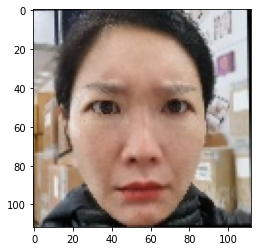

In [59]:
plt.imshow(aligned)

In [60]:
save_aimg = cv2.cvtColor(aligned,cv2.COLOR_RGB2BGR)
cv2.imwrite("./test_aimg.jpg",save_aimg)

True

In [15]:
pred, label = model.fit(aligned)

predict: anxious


In [16]:
print(pred,label)
print(image_path)

3 anxious
/data/shared/Face/FaceEmotion/datasets/emotion_dataset/dataset/Neutral/0c74b84ddba329d0957741b383064db889bb1c4d9840ced0269f6a9ef.jpg


In [11]:
# aihub

csv_path = "aihub_dataset/FaceEmotion_221031/Test_aligned112.csv"
df = pd.read_csv(csv_path,header=None)
not_detect=[]

if lb_num==7:
    labels_dict = {'기쁨':"happy",'당황':"embarrassed",'분노':"anger",'불안':"anxious",'상처':"hurt",'슬픔':"sorrow",'중립':"neutrality"}
    label_index = {'기쁨':0,'당황':1,'분노':2,'불안':3,'상처':4,'슬픔':5,'중립':6}
elif lb_num==5:
    labels_dict = {'기쁨':"happy",'당황':"surprise",'분노':"anger",'불안':"surprise",'상처':"sorrow",'슬픔':"sorrow",'중립':"neutrality"}
    label_index = {'기쁨':0,'당황':1,'분노':2,'불안':1,'상처':3,'슬픔':3,'중립':4}

result_dict={}
for vi,val in enumerate(tqdm(df.values)):
    ori_id,new_id,gender,age,emotion_ko,bboxes_str,ori_path,new_path = val
    result_dict[vi]=[]
    
    image_path = new_path.replace('aligned_data/','aihub_dataset/FaceEmotion_221031/')
    img = read_image(image_path)
    faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,input_size=(640,640))
    if len(faces)<1:
        not_detect.append(vi)
        continue
    land = faces[0].land5

    aligned = face_align(img,LMARK_REF_ARC,land,out_size=112)
    pred, label = model.fit(aligned)
    emotion = labels_dict[emotion_ko]
    gt = label_index[emotion_ko]
    
    result_dict[vi]=[gt,pred]

if lb_num==7:
    ct=[0,0,0,0,0,0,0]
    ct_true=[0,0,0,0,0,0,0]
    index_false={0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
elif lb_num==5:
    ct=[0,0,0,0,0]
    ct_true=[0,0,0,0,0]
    index_false={0:[],1:[],2:[],3:[],4:[]}

for rk in tqdm(result_dict):
    if rk in not_detect: continue
    gt,pred = result_dict[rk]
    ct[gt]+=1
    if gt==pred:
        ct_true[gt]+=1
    else:
        index_false[gt].append([rk,pred])

ct = np.array(ct)
ct_true = np.array(ct_true)

acc = ct_true/ct

100%|██████████| 15642/15642 [00:00<00:00, 934071.35it/s]


In [12]:
print(acc)

[0.94720497 0.86336101 0.84673816 0.83694923 0.92525889]


In [13]:
if lb_num==7:
    labels_list = ['기쁨','당황','분노','불안','상처','슬픔','중립']
elif lb_num==5:
    labels_list = ['기쁨','놀람','분노','슬픔','중립']

for i in range(lb_num):
    ct_check=np.zeros(lb_num)
    for result in index_false[i]:
        idx,pred = result
        ct_check[pred]+=1
    print(labels_list[i],"({}), acc: {} %".format(ct[i],round(acc[i]*100,2)))
    rank = np.argsort(ct_check)[::-1][:-1]
    rank_label = ""
    for r in rank:
        if ct_check[r]==0: continue
        rank_label+="{}({}) -".format(labels_list[r],ct_check[r])
    rank_label = ">> "+rank_label[:-1]+"\n"
    print(rank_label)

기쁨 (2254), acc: 94.72 %
>> 놀람(52.0) -중립(27.0) -슬픔(26.0) -분노(14.0) 

놀람 (4457), acc: 86.34 %
>> 슬픔(392.0) -분노(119.0) -중립(82.0) -기쁨(16.0) 

분노 (2238), acc: 84.67 %
>> 놀람(159.0) -슬픔(141.0) -중립(37.0) -기쁨(6.0) 

슬픔 (4471), acc: 83.69 %
>> 놀람(478.0) -중립(139.0) -분노(103.0) -기쁨(9.0) 

중립 (2221), acc: 92.53 %
>> 슬픔(79.0) -놀람(58.0) -분노(15.0) -기쁨(14.0) 



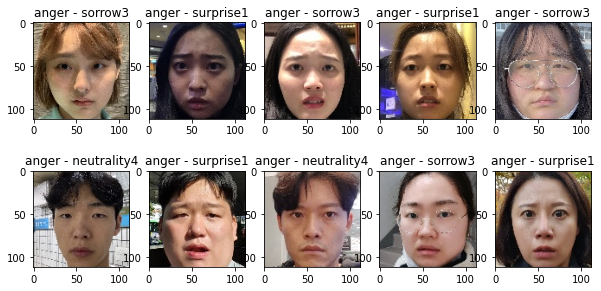

In [22]:
plt.figure(figsize=(10,5))
if lb_num==7:
    label_list = ["happy","embarrassed","anger","anxious","hurt","sorrow","neutrality"]
else:
    label_list = ['happy','surprise','anger','sorrow','neutrality']
    
c=1
for result in index_false[2][:10]:
    idx,pred = result
    ori_id,new_id,gender,age,emotion_ko,bboxes_str,ori_path,new_path = df.values[idx]
    image_path = new_path.replace('aligned_data/','FaceEmotion_221031/')
    img = read_image(image_path)
    
    plt.subplot(2,5,c)
    plt.title("{} - {}{}".format("anger",label_list[pred],pred))
    plt.imshow(img)
    c+=1

In [28]:
for val in df.values:
    ori_id,new_id,gender,age,emotion_ko,bboxes_str,ori_path,new_path = val
    if "당황" in ori_path:
        break

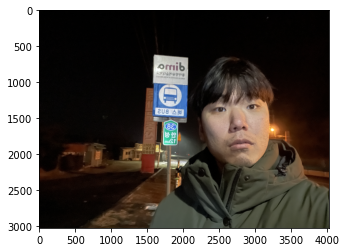

In [30]:
img = read_image(ori_path)
plt.imshow(img)

In [ ]:
# FACES

base = "FACES/ori_images/"
not_detect=[]

label_index = {'neutrality':6, 'happy':0, 'anxious':3, 'anger':2, 'sorrow':5} # not 1,4

result_dict={}
image_list=[name for name in os.listdir(base) if not ".DS" in name]

for vi,filename in enumerate(tqdm(image_list)):
    result_dict[vi]=[]
    
    img_path = os.path.join(base,filename)
    img = read_image(img_path)
    faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,input_size=(640,640))
    if len(faces)<1:
        not_detect.append(vi)
        continue
    land = faces[0].land5

    aligned = face_align(img,LMARK_REF_ARC,land,out_size=112)
    pred, label = model.fit(aligned)
    emotion = img_path.split("/")[-1].split("_")[0]
    gt = label_index[emotion]
    result_dict[vi]=[gt,pred]

In [192]:
ct=[0,0,0,0,0,0,0]
ct_true=[0,0,0,0,0,0,0]
index_false={0:[],1:[],2:[],3:[],4:[],5:[],6:[]}

for rk in tqdm(result_dict):
    if rk in not_detect: continue
    gt,pred = result_dict[rk]
    ct[gt]+=1
    if gt==pred:
        ct_true[gt]+=1
    else:
        index_false[gt].append([rk,pred])

ct = np.array(ct)
ct_true = np.array(ct_true)

acc = ct_true/ct

100%|██████████| 60/60 [00:00<00:00, 151692.73it/s]
/tmp/ipykernel_3613/2362031339.py:17: RuntimeWarning: invalid value encountered in divide
  acc = ct_true/ct


In [193]:
# labels_list = ['기쁨','당황','분노','불안','상처','슬픔','중립']

In [195]:
label_list

['neutrality', 'happy', 'anxious', 'anger', 'sorrow']

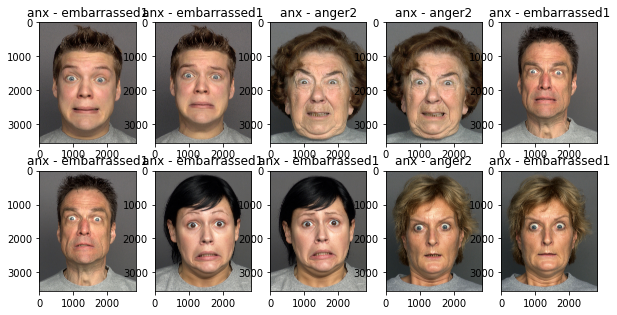

In [196]:
plt.figure(figsize=(10,5))
if lb_num==7:
    label_list = ["happy","embarrassed","anger","anxious","hurt","sorrow","neutrality"]
else:
    
c=1
for result in index_false[3]:
    idx,pred = result
    img_path = os.path.join(base,image_list[idx])
    img = read_image(img_path)
    
    plt.subplot(2,5,c)
    plt.title("{} - {}{}".format("anx",label_list[pred],pred))
    plt.imshow(img)
    c+=1

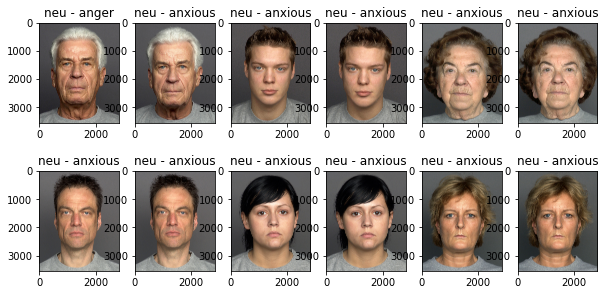

In [181]:
plt.figure(figsize=(10,5))
label_list = list(label_index.keys())
c=1
for result in index_false[6]:
    idx,pred = result
    img_path = os.path.join(base,image_list[idx])
    img = read_image(img_path)
    
    plt.subplot(2,6,c)
    plt.title("{} - {}".format("neu",label_list[pred]))
    plt.imshow(img)
    c+=1